In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.models import Model, load_model
from keras.layers import Input
from keras import optimizers
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import tensorflow as tf
import os

# UNETs
from keras_unet.models import satellite_unet
from keras_unet.models import custom_unet

C:\Users\Aiman\Anaconda3\envs\sticker\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
Using TensorFlow backend.


In [2]:
def batch_ssim(y_true, y_pred):
    return tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))


def batch_msssim(y_true, y_pred):
    return tf.reduce_mean(tf.image.ssim_multiscale(y_true, y_pred, max_val=1.0))


def batch_psnr(y_true, y_pred):
    return tf.reduce_mean(tf.image.psnr(y_true, y_pred, max_val=1.0))


def batch_nmse(y_true, y_pred):
    return tf.divide(tf.reduce_sum(tf.squared_difference(y_true, y_pred)), tf.reduce_sum(y_true ** 2))


def loss_func(labels, predictions):
        return 1 - tf.image.ssim(labels, predictions, max_val=15.0)

In [3]:
#Root directory of the project
ROOT_DIR = os.path.abspath(".")
MODEL_PATH = os.path.join(ROOT_DIR, "models")
TEST_DATASET_PATH = os.path.join(ROOT_DIR, "dataset")
TEST_DATASET_PATH

'E:\\FastMRI\\MRI-reconstruction\\dataset'

In [4]:
TEST_LOW_DIR = "singlecoil_test_3D_images/"
TEST_IMAGES_DIR_PATH = os.path.join(TEST_DATASET_PATH, TEST_LOW_DIR)
TEST_IMAGES_DIR_PATH

'E:\\FastMRI\\MRI-reconstruction\\dataset\\singlecoil_test_3D_images/'

In [5]:
len(os.listdir(TEST_IMAGES_DIR_PATH))

108

In [6]:
test_images = [os.path.join(TEST_IMAGES_DIR_PATH, x) for x in os.listdir(TEST_IMAGES_DIR_PATH)]
len(test_images)

108

### Load the model

In [7]:
model = load_model("unet_v2.h5", custom_objects={'batch_ssim':batch_ssim, 'batch_psnr':batch_psnr, 'batch_msssim':batch_msssim, 'batch_nmse': batch_nmse})
print(model.summary()) #os.path.join(MODEL_PATH, 'unet_1.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 320, 320, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 320, 320, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 320, 320, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 320, 320, 64) 36928       batch_normalization_1[0

In [28]:
def predict(img_3d):
    
    recon = []
    # Make it 4D for inference
    #img_3d = np.moveaxis(img_3d, 0, 2) # whc
    
    slices = img_3d.shape[0]

    # iterate over each slice and save
    for i in range(slices):
        img = img_3d[i,:,:]
        #img = H.normalize(img) # Normalize image
        img =  img[np.newaxis,:,:,np.newaxis]
        img = model.predict(img)
        img = np.squeeze(img, axis=0)
        img = np.reshape(img, (320, 320))
        recon.append(img)
    
    recon = np.array(recon)
    return recon
 

def show_slices(data, slice_nums, cmap=None):
    fig = plt.figure(figsize=(16, 16))
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)

In [66]:
a = np.load(test_images[97])
a.shape

(39, 320, 320)

In [67]:
out_3d = predict(a)
out_3d.shape

(39, 320, 320)

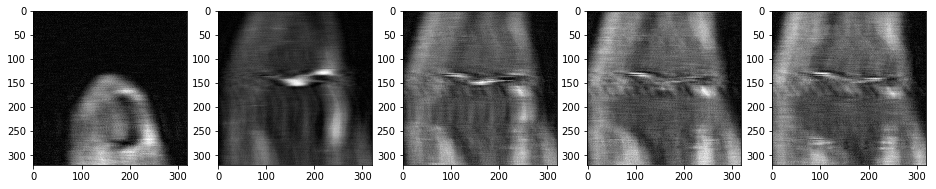

In [68]:
slice_num = [5, 16, 18, 19, 20]
n = 5
show_slices(a, slice_num, cmap='gray')

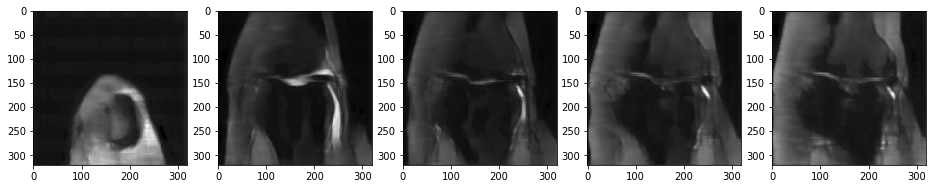

In [69]:
show_slices(out_3d, slice_num, cmap='gray')

In [32]:
fname = test_images[0]
fname[-18:-4]+".h5"

'file1000022_v2.h5'

In [33]:
#RESULTS = "results"
#H.create_directory("{}/{}".format(TEST_DATASET_PATH, RESULTS))
#RESULTS_PATH = os.path.join(TEST_DATASET_PATH, RESULTS)
#RESULTS_PATH

In [34]:
res = {}

for path in tqdm(test_images):
    name = path[-18:-4]+".h5"
    
    vol = np.load(path)
    output = predict(vol)
    
    res[name] = output

100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [04:18<00:00,  2.45s/it]


In [35]:
print("Done!")

Done!


In [38]:
from fastMRI.common import utils as U
from pathlib import Path
import helpers as H

In [39]:
RESULTS_FINAL = "results_final"
H.create_directory("{}/{}".format(TEST_DATASET_PATH, RESULTS_FINAL))
RESULTS_PATH = os.path.join(TEST_DATASET_PATH, RESULTS_FINAL)

In [40]:
RESULTS_PATH

'E:\\FastMRI\\MRI-reconstruction\\dataset\\results_final'

In [41]:
U.save_reconstructions(res, Path(RESULTS_PATH))